In [38]:
import csv
import re
import unicodedata
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

CSV_PATH = "movie.csv"

# Xử lý dữ liệu

In [39]:
with open(CSV_PATH, newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    fieldnames = reader.fieldnames or []
    actor_col = None
    for col in fieldnames:
        folded = unicodedata.normalize("NFKD", col).encode("ascii", "ignore").decode().lower()
        if "dien" in folded and "vien" in folded:
            actor_col = col
            break
    if not actor_col:
        raise RuntimeError(f"Không tìm thấy cột diễn viên. Các cột có: {fieldnames}")

actor_col

'Diễn viên'

In [40]:
def normalize_whitespace(s: str) -> str:
    if not s:
        return ""
    x = unicodedata.normalize("NFKC", s)
    return re.sub(r"\s+", " ", x).strip()

def clean_actor_token(tok: str) -> str:
    """Chỉ bỏ '...' hoặc 'v.v.', còn tên thật thì giữ lại (cắt dấu chấm thừa ở cuối)."""
    if not tok:
        return ""
    x = tok.strip().strip('"').strip("'")
    x = normalize_whitespace(x)

    if re.fullmatch(r"v\.?v\.?|vv", x, flags=re.IGNORECASE):
        return ""
    if re.fullmatch(r"\.+", x):  # toàn dấu chấm
        return ""

    # cắt dấu chấm thừa ở cuối nhưng giữ lại tên
    x = re.sub(r"\.+$", "", x)
    return x.strip()

In [41]:
raw_tokens, clean_tokens = [], []

with open(CSV_PATH, newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        raw = (row.get(actor_col) or "").strip()
        if not raw:
            continue
        for t in raw.replace(";", ",").split(","):
            t = t.strip()
            if t:
                raw_tokens.append(t)

        for t in raw.replace(";", ",").split(","):
            clean = clean_actor_token(t)
            if clean:
                clean_tokens.append(clean)

print("=== Thống kê ===")
print("Tổng lượt diễn viên trước xử lý:", len(raw_tokens))
print("Số diễn viên duy nhất trước xử lý:", len(set(raw_tokens)))
print("Tổng lượt diễn viên sau xử lý:", len(clean_tokens))
print("Số diễn viên duy nhất sau xử lý:", len(set(clean_tokens)))

=== Thống kê ===
Tổng lượt diễn viên trước xử lý: 1066
Số diễn viên duy nhất trước xử lý: 630
Tổng lượt diễn viên sau xử lý: 1048
Số diễn viên duy nhất sau xử lý: 576


## Build Graph

In [42]:
G = nx.Graph()
G.add_nodes_from(set(clean_tokens))

with open(CSV_PATH, newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        raw_val = row.get(actor_col) or ""   # luôn là string
        cast = [clean_actor_token(t) for t in raw_val.replace(";", ",").split(",")]
        cast = [c for c in cast if c]
        if len(cast) >= 2:
            for a, b in itertools.combinations(set(cast), 2):
                if G.has_edge(a, b):
                    G[a][b]["weight"] += 1
                else:
                    G.add_edge(a, b, weight=1)

print("Số node:", G.number_of_nodes())
print("Số cạnh:", G.number_of_edges())

Số node: 576
Số cạnh: 3403


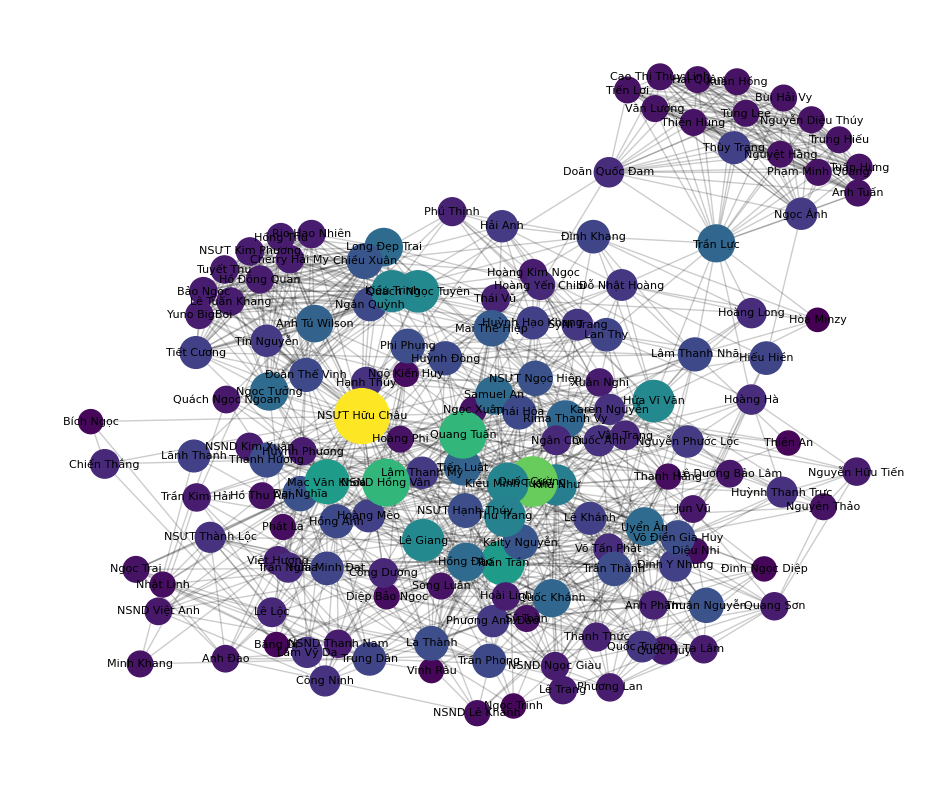

In [46]:
# Vẽ mạng đồng diễn cơ bản (top 150 diễn viên theo degree để dễ nhìn)
deg = dict(G.degree())
top_nodes = sorted(deg, key=deg.get, reverse=True)[:150]
H = G.subgraph(top_nodes)

# layout bố trí node
pos = nx.kamada_kawai_layout(H)  
plt.figure(figsize=(12, 10))

# vẽ cạnh (edges)
nx.draw_networkx_edges(H, pos, alpha=0.2)

chosen_cmap = plt.cm.viridis  

# vẽ node: kích thước và màu theo degree
nx.draw_networkx_nodes(
    H, pos,
    node_size=[deg[n]*20 for n in H.nodes()],
    node_color=[deg[n] for n in H.nodes()],
    cmap=chosen_cmap
)

# vẽ nhãn (tên diễn viên)
nx.draw_networkx_labels(H, pos, font_size=8)

plt.axis("off")
plt.show()

In [47]:
# Tính degree (số kết nối)
degree = dict(G.degree())
nx.set_node_attributes(G, degree, "degree")

# Tính weighted degree (số kết nối có trọng số)
weighted_degree = dict(G.degree(weight="weight"))
nx.set_node_attributes(G, weighted_degree, "weighted_degree")

# Tính betweenness centrality
betweenness = nx.betweenness_centrality(G, weight="weight", normalized=True)
nx.set_node_attributes(G, betweenness, "betweenness")

# Tính eigenvector centrality
eigenvector = nx.eigenvector_centrality_numpy(G, weight="weight")
nx.set_node_attributes(G, eigenvector, "eigenvector")

# In top 10 diễn viên theo từng chỉ số
print("Top 10 diễn viên theo degree:")
for name, val in sorted(degree.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{name}: {val}")

print("\nTop 10 diễn viên theo weighted degree:")
for name, val in sorted(weighted_degree.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{name}: {val}")

print("\nTop 10 diễn viên theo betweenness:")
for name, val in sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{name}: {val:.4f}")

print("\nTop 10 diễn viên theo eigenvector:")
for name, val in sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{name}: {val:.4f}")

Top 10 diễn viên theo degree:
NSƯT Hữu Châu: 78
Quốc Cường: 63
Quang Tuấn: 56
NSND Hồng Vân: 56
Tuấn Trần: 49
Mạc Văn Khoa: 49
Quách Ngọc Tuyên: 44
Hứa Vĩ Văn: 44
Lê Giang: 44
Kiều Minh Tuấn: 43

Top 10 diễn viên theo weighted degree:
NSƯT Hữu Châu: 83
NSND Hồng Vân: 64
Quốc Cường: 63
Quang Tuấn: 60
Tuấn Trần: 57
Thu Trang: 52
Mạc Văn Khoa: 52
Kiều Minh Tuấn: 51
Lê Giang: 51
Quách Ngọc Tuyên: 50

Top 10 diễn viên theo betweenness:
NSƯT Hữu Châu: 0.1016
Quốc Cường: 0.0730
Quang Tuấn: 0.0589
NSND Hồng Vân: 0.0545
Hứa Vĩ Văn: 0.0408
Mạc Văn Khoa: 0.0358
Thanh Hương: 0.0348
Quách Ngọc Tuyên: 0.0337
Trần Lực: 0.0334
Công Ninh: 0.0317

Top 10 diễn viên theo eigenvector:
NSƯT Hữu Châu: 0.2571
NSND Hồng Vân: 0.1823
Kiều Minh Tuấn: 0.1815
Thu Trang: 0.1771
Tuấn Trần: 0.1697
Quách Ngọc Tuyên: 0.1628
Ngọc Tưởng: 0.1581
Long Đẹp Trai: 0.1504
Lê Giang: 0.1487
Kiều Trinh: 0.1468


In [45]:
# Xuất đồ thị sang Gephi
nx.write_gexf(G, "coacting.gexf")
nx.write_graphml(G, "coacting.graphml")
